# Regression Models

## Grouping countries for models
## Creating datasets for groups
- regression 1 (cluster 1)
    - Algeria, Argentina, Australia, Belgium, Chile, France, Indonesia, Italy, Kazakhstan, Kuwait, Malaysia, Mexico, Netherlands, New Zealand, Nigeria, Poland, Portugal, Romania, Saudi Arabia, South Africa, Spain, Sweden, Thailand, Turkey, Ukraine, United Arab Emirates, United Kingdom, Uzbekistan
- regression 2 (cluster 2)
    - Norway
- regression 3 (clusters 0, 3, 4)
    - US, China, Brazil
- regression 4 (cluster 5)
    - Canada, Colombia, Germany, India, Japan
    
## Summary table of results
|Cohort|Train score|Test score|
|---|---|---|---|
|**regression 1**|**0.999**|**-0.552**|
|**regression 2**|**1.0**|**0.0**|
|regression 3|1.0|0.998|
|regression 4|1.0|0.99|  

## Notebook Contents
- [Grouping countries & dataframe subsets](#location)
- [standard regressions](#regressions)
- [autoregressive models](#autoregressions)
- [Bayesian regression](#bayesian)
- [Summary of outputs](#summary) 

Further analysis of these models and comparisons to other models can be found in the [Model Comparison notebook](https://github.com/sonyah-hawaii/time_series_regressive_modeling/blob/master/Model%20Comparison.ipynb)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
abatement_historical = pd.read_csv('./Data/abatement_calculations.csv')

In [3]:
abatement_historical.set_index('country', inplace=True)
abatement_historical = abatement_historical

In [4]:
regression_1 = abatement_historical[abatement_historical.label==1]
regression_2 = abatement_historical[abatement_historical.label==2]
regression_3 = abatement_historical.loc[(abatement_historical.label==0)
                                         |(abatement_historical.label==3)
                                        |(abatement_historical.label==4)]
regression_4 = abatement_historical[abatement_historical.label==5]

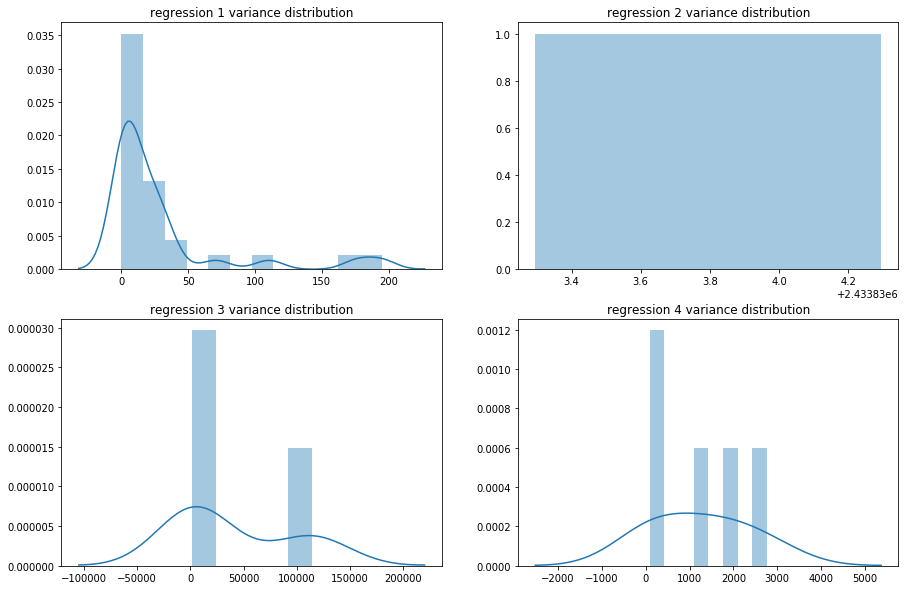

In [5]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.distplot(regression_1.drop('label', axis=1).T.var());
plt.title('regression 1 variance distribution');

plt.subplot(2,2,2)
sns.distplot(regression_2.drop('label', axis=1).T.var());
plt.title('regression 2 variance distribution');

plt.subplot(2,2,3)
sns.distplot(regression_3.drop('label', axis=1).T.var(), bins=5);
plt.title('regression 3 variance distribution');

plt.subplot(2,2,4)
sns.distplot(regression_4.drop('label', axis=1).T.var(), bins=8);
plt.title('regression 4 variance distribution');

## Standard Regressions
<a id='regressions'></a>

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

|lr|regression_1|0.9992163041108283|-0.5519844061983625|
|rf|regression_1|0.9658568399264474|0.9089165459943134|


|lr|regression_2|1.0|0.0|
|rf|regression_2|0.0|0.0|


|lr|regression_3|1.0|0.9975695328033146|
|rf|regression_3|0.6452134980394797|0.6325373394577631|


|lr|regression_4|1.0|0.9903118716080075|
|rf|regression_4|0.7090185910794264|0.6933997502956621|




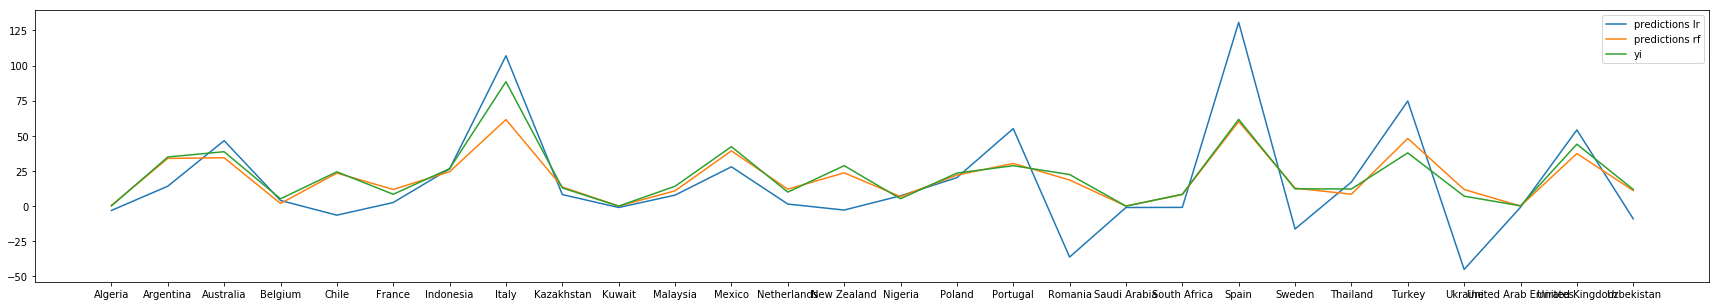

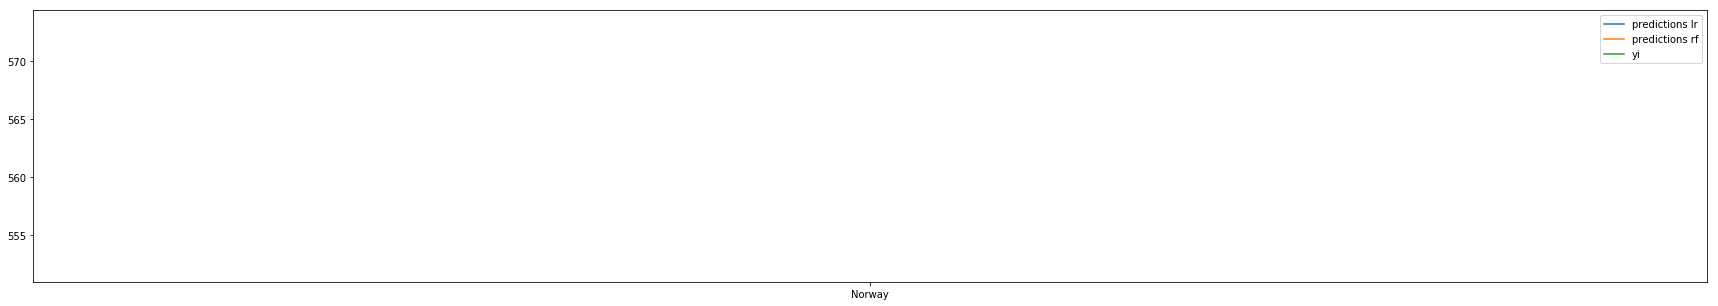

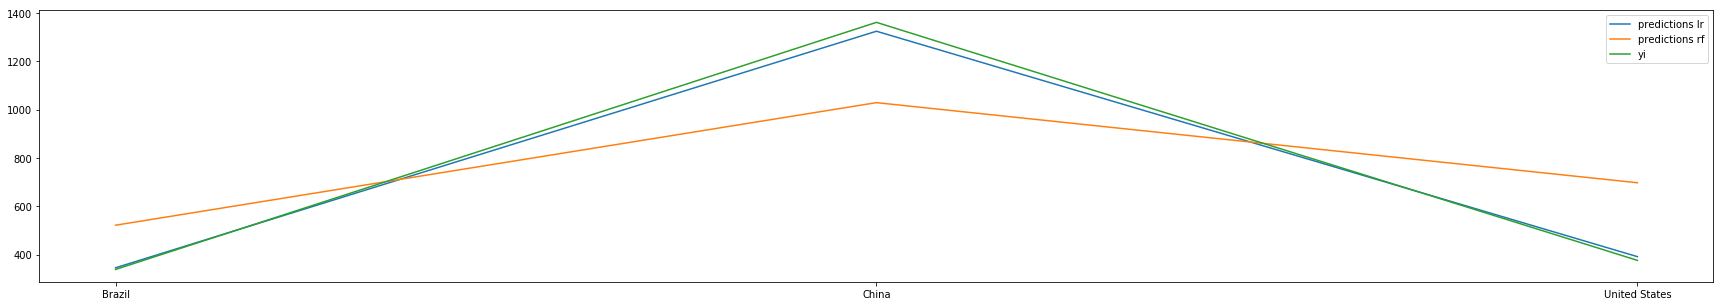

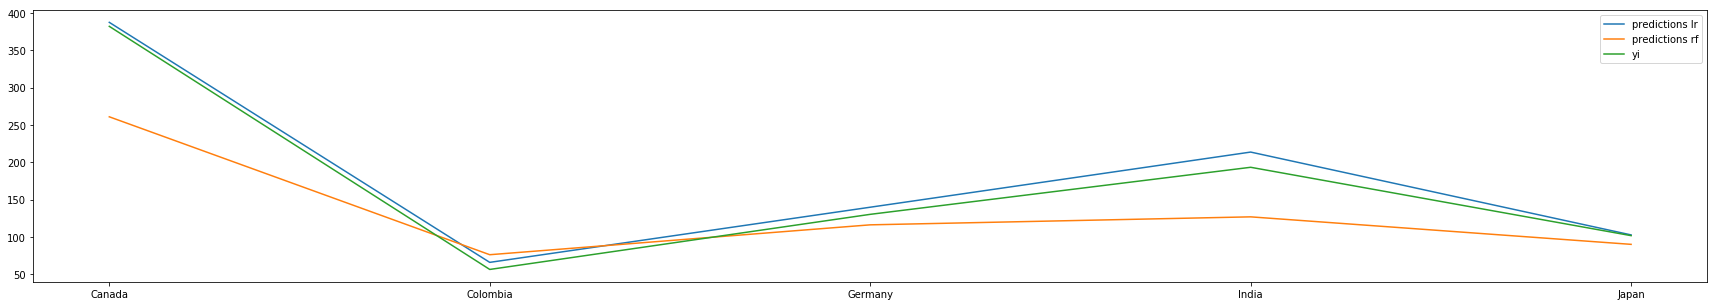

In [7]:
#Code to generate predictions and results for summary table
subsets = ['regression_1', 'regression_2','regression_3','regression_4']

for i in subsets:
    #generating scores
    train = eval(i).loc[:, :'2012']
    train_y = eval(i).loc[:, '2013']
    test = eval(i).loc[:, '1991':'2013']
    test_y =  eval(i).loc[:, '2014']
    
    #generating linear regression outputs
    lr = LinearRegression()
    lr.fit(train, train_y)
    lr.predict(test)
    
    #generating random forest regressor outputs
    rf = RandomForestRegressor(random_state=94)
    rf.fit(train, train_y)
    rf.predict(test)
    
    #printing out structure for summary table
    print(f'|lr|{i}|{lr.score(train, train_y)}|{lr.score(test, test_y)}|')
    print(f'|rf|{i}|{rf.score(train, train_y)}|{rf.score(test, test_y)}|')
    print('\n')
    #generating plots
    plt.figure(figsize=(30,5))
    plt.plot(lr.predict(test), label='predictions lr');
    plt.plot(rf.predict(test), label='predictions rf');
    plt.plot(test_y, label='yi');
    plt.legend();

## Autoregressions
<a id='autoregressions'></a>

Based on the output of the regular regression, we're going to try ensembling together autoregressions for all countries within the 1st cohort.

## Bayesian Regressions
<a id='bayesian'></a>

This process was adapted from a notebook developd by Phillippa Thomson

In [8]:
from pymc3 import Model, Normal, HalfNormal
from pymc3 import find_MAP
from pymc3 import NUTS, sample
from scipy import optimize
from pymc3 import traceplot
from sklearn.preprocessing import StandardScaler

In [9]:
#building lagged dataframe
dataset = pd.DataFrame()
dataset['target'] = regression_1[regression_1.index=='Algeria'].T.iloc[:,0]
for i in range(1, 16):
    dataset[f'lag{i}'] = dataset['target'].shift(i)
dataset.drop('label', inplace=True)
dataset = dataset.loc['2005':]
train = dataset[0:5]
val = dataset[5:-1]
test = dataset[-1:]

#setting up train, val, test
train_target = train['target']
val_target = val['target']
test_target = test['target']

#setting up x and y for MCMC
y = np.array(train_target).reshape(-1,1)
X = np.array(train.drop('target', axis=1))
ss = StandardScaler()
X = ss.fit_transform(X)

#setting standard deviation to feed into the mcmc model
mcmc_std = train_target.std()

In [10]:
#priors definitions
#likelihood equation set up
#structure set up here

basic_model = Model()
with basic_model:
    # start by defining distribution for all parameters
    # use sd to determine strength of the prior
    # big sd is a weak prior
    intercept = Normal('intercept', mu=0, sd=mcmc_std)
    # the shape on beta is the number of features in the fit
    beta = Normal('beta', mu=0, sd=mcmc_std, shape=15)
    # sigma is the width of the gaussian around yhat
    # (i.e. related to the size of the residuals)
    sigma = HalfNormal('sigma', sd=1)

    # create a formula for yhat
    y_hat = intercept + beta * X

    # simulate data as a distribution around yhat
    Y_obs = Normal('Y_obs', mu=y_hat, sd=sigma, observed=y)

In [11]:
#posterior calculations
#not full MCMC but giving you an estimate of the most likely values for unknown coefficients
map_estimate = find_MAP(model=basic_model)
print(map_estimate)

logp = 64.645, ||grad|| = 5.6045: 100%|██████████| 17/17 [00:00<00:00, 1260.37it/s]  


{'intercept': array(0.3112147), 'beta': array([-0.02692581, -0.0246623 , -0.0783784 , -0.03466686, -0.02947492,
        0.07864392,  0.06449008, -0.05876225, -0.01415467,  0.06848933,
        0.01724879,  0.09271555, -0.01695529,  0.03951225, -0.07173919]), 'sigma_log__': array(-2.11787321), 'sigma': array(0.12028718)}


In [12]:
#this component is doing the sampling of those distributions
#mcmc

with basic_model:
    trace = sample(2000,cores=1) #set to sample twice so your predictions can be compared

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_log__, beta, intercept]
100%|██████████| 2500/2500 [00:05<00:00, 476.95it/s]


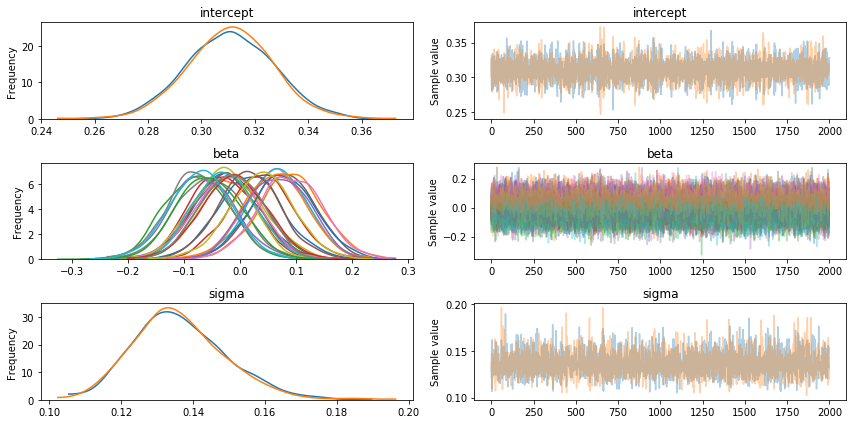

In [13]:
#look into breaking this stuff apart for better analysis

#intercept is the posterior
#the data informed the uncertainty around the intercept
#which forced it to be smaller and better align with the data 
traceplot(trace);

In [14]:
len(trace)

2000

In [15]:
#takes in inputs (X) and generates an entire range of 2000 predictions (y_hat)

params = []
for i in trace:
    sigma = i['sigma']
    eps = np.random.normal(0, sigma)
    y_hat = i['intercept'] + np.matmul(X, i['beta']) + eps
    params.append(y_hat)

In [ ]:
# plt.figure(figsize=(15,10))
# plt.subplot(2,2,1)
# sns.distplot(trace['intercept']);
# plt.title('Distribution of intercepts');

# plt.subplot(2,2,2)
for i in range(len(trace['beta'])):
    sns.distplot(trace['beta'][i]);
    plt.title(f'Distribution of betas for {i}');

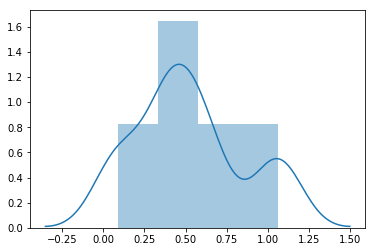

In [334]:
#this represents distribution of 2000 predictions
#generated for the first row in X
sns.distplot(params[0]);

In [337]:
# from __future__ import division
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline
# import seaborn as sns
from scipy.integrate import quad

In [341]:
beta = 2
sigma = 1
pdf = lambda x, y: np.sqrt(1/(2*sigma**2*np.pi))\
                *np.exp((-1/(2*sigma**2))*(y-beta*x)**2)

X = np.linspace(0,5, 500)
Y = np.linspace(0,10, 500)
X, Y = np.meshgrid(X, Y)
pdf_vec = np.vectorize(pdf)

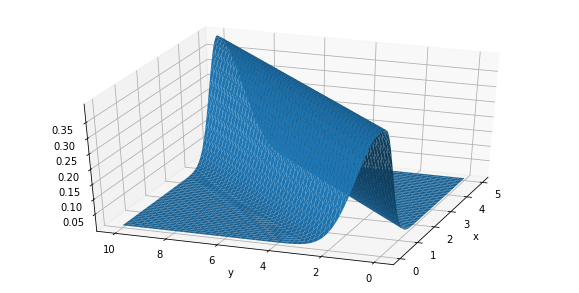

In [342]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1, projection = '3d')
ax1.plot_surface(X, Y, pdf_vec(X, Y))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.view_init(elev=35, azim=200)

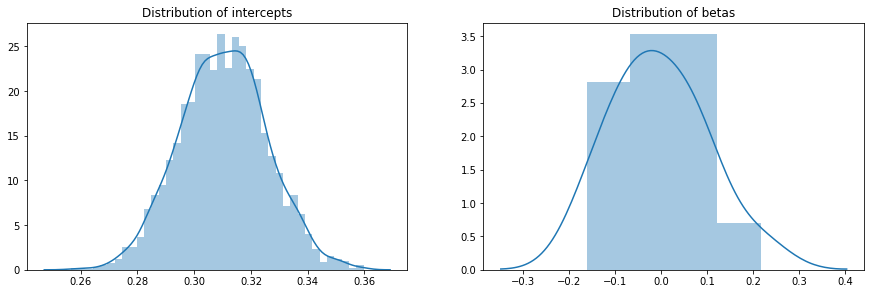

In [ ]:
#do same thing for val

#do same thing for test


- build a dataframe where features are lagged timepoints
- target is the next feature in the progression  
  
- specify priors on all coefficients
- specify priors on variance of data
- plug things into the model 
- follow pymc3 lesson

- goal is actually a posterior predictive
- pyflux provides uncertainty bounds (UL + LL)
- for a highly generalized bayesian regression try pymc3
    - you  need to specify priors and distributions
    - begin with something relatively uninformative (broad gaussian, uniform, etc.) 
    
1. write out an equation, which model inteded (ex. regression + variance)
2. specify priors for each coefficient, prior on variance
    - pymc3 this means creating new objects 
3. take existing objects/variables that contain priors and build a likelihood distribution with observed data
    - prior variables act as parameters
    - MCMC
4. estimate y-hat and save values
    - this is where we capture variance
    - write out a function to pull samples from these distributions
    - codify the samples pulled, **construct a distribution of y-hat** fitting to obtain bounds and represent uncertainty or anticipated variance
        - we can use this to set a confidence interval
    - combining these observations to understand uncertainty is where this gets shaky

In [288]:
#for loop to build train, val, test dataframes for each country within Cohort 1
for country in regression_1.index:
    dataset = pd.DataFrame()
    dataset['target'] = regression_1[regression_1.index==country].T.iloc[:,0]
    for i in range(1, 16):
        dataset[f'lag{i}'] = dataset['target'].shift(i)
    dataset.drop('label', inplace=True)
    dataset = dataset.loc['2005':]
    train = dataset[0:5]
    val = dataset[5:-1]
    test = dataset[-1:]

## Summary
<a id='summary'></a>